<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model  import LogisticRegression, LinearRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score , mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 기계학습 (60점)

## 데이터 설명
- 데이터 출처 : https://archive.ics.uci.edu/ml/datasets/HCV+data 후처리
- 데이터 링크 : ./data/p1.csv
- 데이터 설명 : 혈액수치 데이터, 간염 정도에 따른

Category (종속변수)
- 0: 정상
- 1,2,3 (간염 정도, 심각성 : 3>2>1, 3은 간경화)


In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/ADP_SONY/ADP_33회/p1.csv")
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=B,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=B,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=B,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0=B,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0=B,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


#### ✅ 1-1  결측치 처리 방안 2개 제시하고, 처리 전후 비교 및 더 나은 방안 선택하여 전처리 완료

In [4]:
print(df.shape)
print(df.isna().sum().to_frame().T)
print('''
전체 데이터의 수는 608개이며, ALP 18개, ALT 1개, PROT 1 개로 결측이 있다.
''')
display(df.describe())

(608, 13)
   Category  Age  Sex  ALB  ALP  ALT  AST  BIL  CHE  CHOL  CREA  GGT  PROT
0         0    0    0    1   18    1    0    0    0    10     0    0     1

전체 데이터의 수는 608개이며, ALP 18개, ALT 1개, PROT 1 개로 결측이 있다. 



,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,608.000000,607.000000,590.000000,607.000000,608.000000,608.000000,608.000000,598.000000,608.000000,608.000000,607.000000
mean,47.291118,41.818781,67.821017,27.601318,34.369408,11.474013,8.204885,5.378829,81.513158,38.243914,72.253213
std,9.992705,5.406717,25.274423,21.227539,32.622442,19.770558,2.168400,1.119394,49.720652,51.953220,4.932252
min,19.000000,20.000000,11.300000,0.900000,12.000000,1.800000,1.420000,1.430000,8.000000,4.500000,51.000000
25%,39.000000,39.000000,52.500000,16.400000,21.600000,5.300000,6.950000,4.620000,68.000000,15.700000,69.450000
50%,47.000000,42.000000,66.000000,23.000000,25.850000,7.300000,8.270000,5.300000,77.000000,23.250000,72.200000
75%,54.000000,45.250000,79.525000,32.750000,32.800000,11.300000,9.585000,6.075000,88.000000,39.200000,75.400000
max,77.000000,82.200000,416.600000,258.000000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


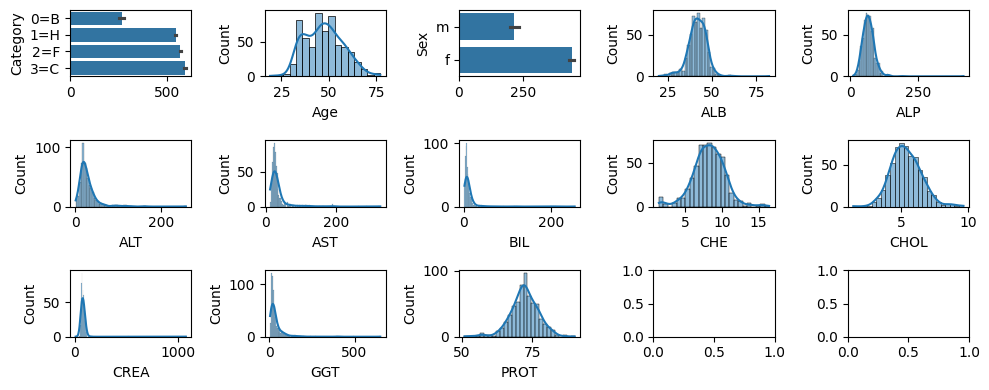


결측 처리 전, 데이터의 분포를 확인한 결과 대부분 정규분포를 따르거나 한쪽으로 밀집된 형태이다. 
이에 따라, 결측값 처리 방법으로는 다음 두 가지를 제시한다.

① 변수별 평균값을 이용한 대체: 데이터 유실을 방지할 수 있으며, 분포 특성상 평균값 대체가 왜곡을 최소화할 수 있음  
② 결측값 포함 행 제거: 전체 데이터 수 대비 결측 비율이 3% 이하로 매우 낮아 삭제에 따른 영향이 크지 않음

두 방식으로 처리 후, 모델 성능 및 데이터 분포 변화 등을 비교하여 더 적절한 방법을 선택한다.



In [5]:
fig, axes = plt.subplots(3,5, figsize = (10, 4))

for i, axes in enumerate(axes.flat[:len(df.columns)]):
  col_i = df.columns[i]
  if df[col_i].dtype == 'object' :
    sns.barplot(df[col_i], ax = axes)

  else :
    sns.histplot(df[col_i], kde = True, ax = axes)

plt.tight_layout()
plt.show()
print('''
결측 처리 전, 데이터의 분포를 확인한 결과 대부분 정규분포를 따르거나 한쪽으로 밀집된 형태이다.
이에 따라, 결측값 처리 방법으로는 다음 두 가지를 제시한다.

① 변수별 평균값을 이용한 대체: 데이터 유실을 방지할 수 있으며, 분포 특성상 평균값 대체가 왜곡을 최소화할 수 있음
② 결측값 포함 행 제거: 전체 데이터 수 대비 결측 비율이 3% 이하로 매우 낮아 삭제에 따른 영향이 크지 않음

두 방식으로 처리 후, 모델 성능 및 데이터 분포 변화 등을 비교하여 더 적절한 방법을 선택한다.
''')

In [6]:
# ['ALB', 'ALP','ALT','CHOL', 'PROT]

# 평균대체
df_mean = df.copy()
for col in df_mean.columns :
  if df_mean[col].isna().sum() > 0 :
    df_mean[col] = df_mean[col].fillna(df_mean[col].mean())

df_mean.shape

# 삭제 처리
df_drop = df.copy()
df_drop = df_drop.dropna()
df_drop.shape

table_mean = df_mean.describe().T[['mean','std','min','max']]
table_mean.columns = ['평균대체_mean' ,'평균대체_std','평균대체_min','평균대체_max']
table_drop = df_drop.describe().T[['mean','std','min','max']]
table_drop.columns = ['삭제_mean' ,'삭제_std','삭제_min','삭제_max']

res = pd.concat([table_mean, table_drop] , axis = 1)
display(res)

display(df.describe().T[['mean','std','min','max']])

print(f'''
평균 대체 시 : {df_mean.shape}
삭제 처리 일 때 : {df_drop.shape} 으로 삭제 처리일떄 결측 만큼의 데이터 유실이 생겼다.
평균으로 대체하는 경우와 삭제 처리를 했을때 결측이 가장 많았던 ALP 의 경우 평균과 표준편차에서 크게 차이가 나지 않는다.
데이터의 수가 608개인것을 가만하여, 평균 대체를 사여 분석에 사용한다.
''')

,평균대체_mean,평균대체_std,평균대체_min,평균대체_max,삭제_mean,삭제_std,삭제_min,삭제_max
Age,47.291118,9.992705,19.00,77.00,47.295533,9.863890,23.00,77.00
ALB,41.818781,5.402261,20.00,82.20,41.831443,5.369272,23.00,82.20
ALP,67.821017,24.896859,11.30,416.60,67.651890,25.148941,11.30,416.60
ALT,27.601318,21.210046,0.90,258.00,25.666838,14.920906,0.90,118.10
AST,34.369408,32.622442,12.00,324.00,33.325086,32.357234,12.00,324.00
BIL,11.474013,19.770558,1.80,254.00,11.094330,17.494290,1.80,209.00
CHE,8.204885,2.168400,1.42,16.41,8.212337,2.151660,1.42,16.41
CHOL,5.378829,1.110135,1.43,9.67,5.402646,1.114920,1.43,9.67
CREA,81.513158,49.720652,8.00,1079.10,81.909107,50.669976,8.00,1079.10
GGT,38.243914,51.953220,4.50,650.90,36.835567,51.409352,4.50,650.90


,mean,std,min,max
Age,47.291118,9.992705,19.00,77.00
ALB,41.818781,5.406717,20.00,82.20
ALP,67.821017,25.274423,11.30,416.60
ALT,27.601318,21.227539,0.90,258.00
AST,34.369408,32.622442,12.00,324.00
BIL,11.474013,19.770558,1.80,254.00
CHE,8.204885,2.168400,1.42,16.41
CHOL,5.378829,1.119394,1.43,9.67
CREA,81.513158,49.720652,8.00,1079.10
GGT,38.243914,51.953220,4.50,650.90



평균 대체 시 : (608, 13) 
삭제 처리 일 때 : (582, 13) 으로 삭제 처리일떄 결측 만큼의 데이터 유실이 생겼다. 
평균으로 대체하는 경우와 삭제 처리를 했을때 결측이 가장 많았던 ALP 의 경우 평균과 표준편차에서 크게 차이가 나지 않는다. 
데이터의 수가 608개인것을 가만하여, 평균 대체를 사여 분석에 사용한다. 



## 1-2 이상치를 확인하고 처리 여부 판단 후 작업


대부분의 데이터에서 이상치가 있는 것으로 판단되어진다. 하지만 간염 등급과 데이터의 수를 고려하면
이상치가 등급을 정하는 요인으로 판단될 수 있기 때문에 이상치 처리를 하지 않는다. 



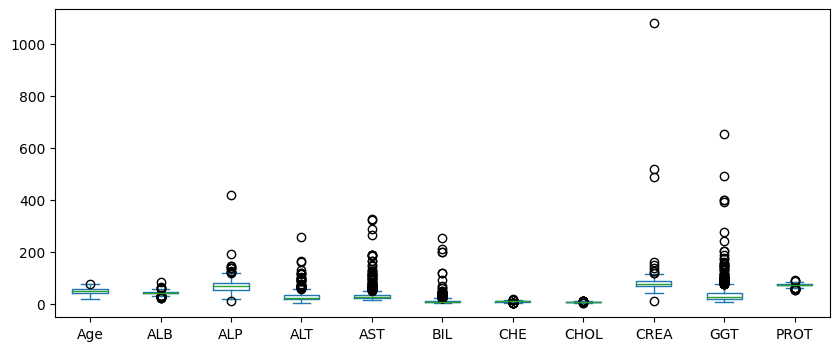

In [7]:
# df_mean
cols = df_mean.select_dtypes(exclude = 'object').columns.to_list()
df_mean[cols].plot(kind = 'box' , figsize = (10,4))

print('''
대부분의 데이터에서 이상치가 있는 것으로 판단되어진다. 하지만 간염 등급과 데이터의 수를 고려하면
이상치가 등급을 정하는 요인으로 판단될 수 있기 때문에 이상치 처리를 하지 않는다.
''')

#### ✅1-3 위 두 작업 적용 후 EDA 진행 및 종속변수를 기준으로 각 독립변수의 차이가 있는지 확인하라 (시각화포함)

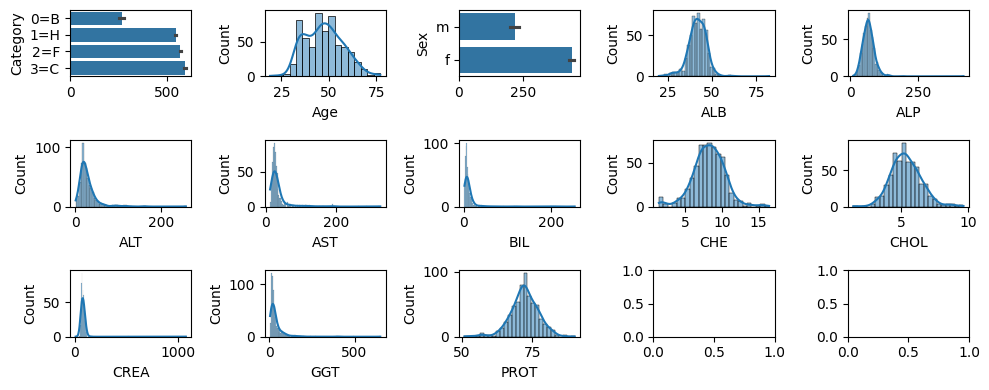

In [8]:
fig, axes = plt.subplots(3,5, figsize = (10, 4))

for i, axes in enumerate(axes.flat[:len(df_mean.columns)]):
  col_i = df.columns[i]
  if df_mean[col_i].dtype == 'object' :
    sns.barplot(df_mean[col_i], ax = axes)

  else :
    sns.histplot(df_mean[col_i], kde = True, ax = axes)

plt.tight_layout()
plt.show()

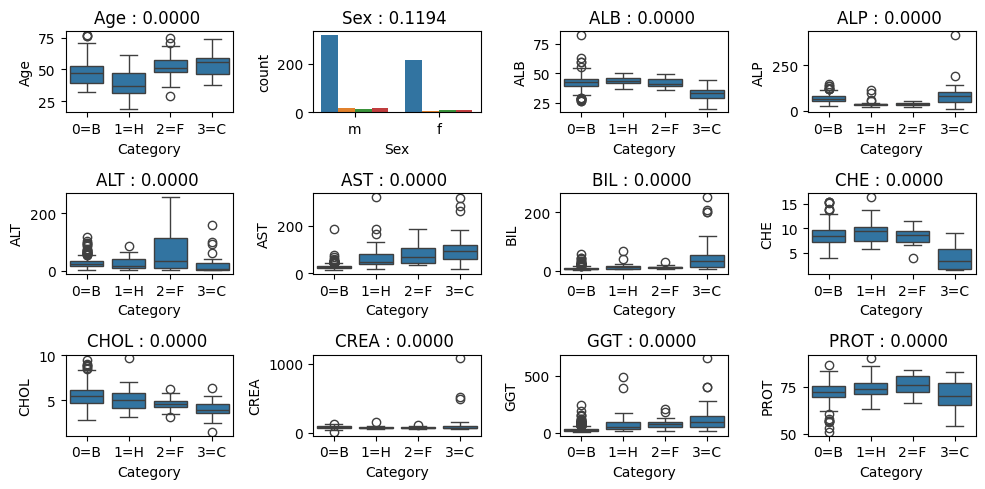

,col,p_val
0,Age,9.425871e-08
1,Sex,1.193555e-01
2,ALB,5.808575e-21
3,ALP,3.443465e-11
4,ALT,2.507966e-11
5,AST,4.194864e-74
6,BIL,4.000225e-48
7,CHE,3.336676e-32
8,CHOL,9.641726e-13
9,CREA,2.680767e-09



귀무가설 : 종속변수를 기준으로 각 독립변수의 차이가 없다. 
대립가설 : 종속변수를 기준으로 각 독립변수의 차이가 있다. 

범주형 변수는 카이제곱으로, 숫자형 변수는 ANOVA 분석을 통해 분석한 결과 모든 컬럼의 p_val < 0.05 으로 Category(종속변수)별 
각 컬럼의 평균이 다르다는 결론이 나왔다. 



In [9]:
#  종속변수를 기준으로 각 독립변수의 차이가 있는지 확인  ['0=B', '1=H', '2=F', '3=C']
import scipy.stats as stats

fig, axes = plt.subplots(3,4, figsize = (10, 5))

res = []
for i, axes in enumerate(axes.flat[:len(df_mean.columns[1:])]):
    col_i = df_mean.columns[1:][i]
    if df_mean[col_i].dtype == 'object' :
      target = pd.crosstab(df_mean[col_i], df_mean['Category'])
      stat, p_val, dof, expected = stats.chi2_contingency(target)
      sns.countplot(data = df_mean, x = col_i, hue = 'Category', ax = axes)
      axes.set_title(f'{col_i} : {p_val:.4f} ')


    else:
      groups = [df_mean[df_mean['Category'] == g ][col_i] for g in df_mean['Category'].unique()]
      f_val , p_val = stats.f_oneway(*groups)
      sns.boxplot(x = 'Category', y = df[col_i], data = df_mean, ax = axes)
      axes.set_title(f'{col_i} : {p_val:.4f} ')

    res.append([col_i, p_val])

    if axes.get_legend() :
      axes.get_legend().remove()


plt.tight_layout()
plt.show()

display(pd.DataFrame(res, columns = ['col','p_val']))
print('''
귀무가설 : 종속변수를 기준으로 각 독립변수의 차이가 없다.
대립가설 : 종속변수를 기준으로 각 독립변수의 차이가 있다.

범주형 변수는 카이제곱으로, 숫자형 변수는 ANOVA 분석을 통해 분석한 결과 모든 컬럼의 p_val < 0.05 으로 Category(종속변수)별
각 컬럼의 평균이 다르다는 결론이 나왔다.
''')

#### ✅ 1-4 주어진 데이터로부터 주성분분석을 수행해 새로운 설명변수를 도출할 수 있는지를 검토 ∙ 판단한 뒤, 그 결과를 제시하시오

,0,1,2,3,4,5,6,7,8,9,10
ratio,0.216058,0.164849,0.128105,0.098711,0.080541,0.070669,0.066784,0.056805,0.044153,0.042646,0.030679
cumsum,0.216058,0.380907,0.509012,0.607723,0.688264,0.758933,0.825717,0.882522,0.926675,0.969321,1.000000



PCA 분석 결과 전체 6개의 주성분이 데이터의 82%을 설명하는 것을 알 수 있다. 이는 전체 분산의 상당 부분을
6개의 주성분으로 설명이 가능하다는 것을 의미하며, 다중공선성과 변수들 간의 상관관계의 문제를 해결할 수 있다고 판단된다.
결론적으로, PCA를 통한 주성분들은 설명 변수로 활용할 수 있는 타당성이 있다고 보여진다. 



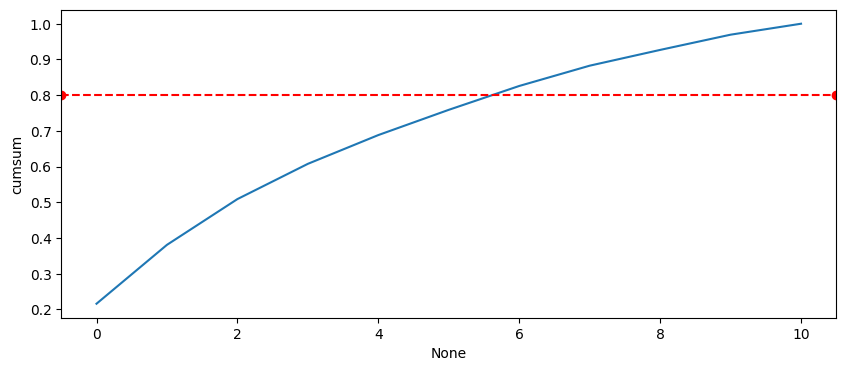

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing  import StandardScaler

num_df = df_mean[df_mean.select_dtypes(exclude = 'object').columns]


ss  = StandardScaler()
scaled_x = pd.DataFrame(ss.fit_transform(num_df) , columns = num_df.columns)

pca = PCA()
pca.fit(scaled_x)

pca_result = pd.DataFrame({
    'ratio' : pca.explained_variance_ratio_,
    'cumsum' : pca.explained_variance_ratio_.cumsum()
})

plt.figure(figsize = (10, 4))
sns.lineplot(x = pca_result.index, y= pca_result['cumsum'])
plt.axhline(0.8, marker = 'o', color = 'red', linestyle = '--')
display(pca_result.T)

print('''
PCA 분석 결과 전체 6개의 주성분이 데이터의 82%을 설명하는 것을 알 수 있다. 이는 전체 분산의 상당 부분을
6개의 주성분으로 설명이 가능하다는 것을 의미하며, 다중공선성과 변수들 간의 상관관계의 문제를 해결할 수 있다고 판단된다.
결론적으로, PCA를 통한 주성분들은 설명 변수로 활용할 수 있는 타당성이 있다고 보여진다.
''')

In [11]:
num_df = df_mean[df_mean.select_dtypes(exclude = 'object').columns]


ss  = StandardScaler()
scaled_x = pd.DataFrame(ss.fit_transform(num_df) , columns = num_df.columns)

pca = PCA(n_components= 6)
pca6_df = pd.DataFrame(pca.fit_transform(scaled_x) , columns = ['PC_' + str(x) for x in range(6)])
#pca6_df

## 2-1 데이터 불균형이 왜 문제인지 설명하고 불균형 해결방법에 대해 두가지를 설명하라

In [12]:
print('''
데이터 불균형이란 특정 클래스가 다른 클래보다 현저히 많거나, 적은 경우를 말한다.
이는 다수의 클래스 혹은 소수의 클래스에만 집중되어 정확도가 떨어지거나, 모델의 정확도를 낮추는 등의 편향이 발생하기
때문에 모델의 신뢰도와 정확도에 문제가 생긴다.

해결 방법)
1. **오버샘플링 (Oversampling)**
   - 소수 클래스의 데이터를 인위적으로 늘려서 다수 클래스와의 비율을 맞추는 방법
   - 예: SMOTE(Synthetic Minority Over-sampling Technique) 등

2. **언더샘플링 (Undersampling)**
   - 다수 클래스의 일부 데이터를 제거하여, 소수 클래스와 균형을 맞추는 방법
   - 데이터 손실 위험이 있지만, 빠르게 불균형을 해소할 수 있음

''')


데이터 불균형이란 특정 클래스가 다른 클래보다 현저히 많거나, 적은 경우를 말한다. 
이는 다수의 클래스 혹은 소수의 클래스에만 집중되어 정확도가 떨어지거나, 모델의 정확도를 낮추는 등의 편향이 발생하기
때문에 모델의 신뢰도와 정확도에 문제가 생긴다.

해결 방법)
1. **오버샘플링 (Oversampling)**  
   - 소수 클래스의 데이터를 인위적으로 늘려서 다수 클래스와의 비율을 맞추는 방법  
   - 예: SMOTE(Synthetic Minority Over-sampling Technique) 등  

2. **언더샘플링 (Undersampling)**  
   - 다수 클래스의 일부 데이터를 제거하여, 소수 클래스와 균형을 맞추는 방법  
   - 데이터 손실 위험이 있지만, 빠르게 불균형을 해소할 수 있음




## 2-2 불균형 데이터 분류모델에 적합한 평가지표 3개 제시하고 그 이유 설명하라

In [13]:
print('''
불균형 데이터인 경우, 정확도 보다는 다음과 같은 좀 더 신뢰성있는 평가 지표를 활용한다.
1) 정밀도 - 양성으로 예측한 것 중에 실제로 맞춘 비율 (TP/(TP+FP))
            예측의 신뢰성을 평가함으로써 FP가 얼마나 줄었는지 알 수 있다.

2) 재현율 - 실제 양성인것을 중에 양성으로 예측한 비율
            소수 클래스 탐지율을 높이는데 중점을 둔다.

3) F1-score - 정밀도, 재현율의 균형을 고려한 불균형 데이터 상황에서 가장 일반적으로 신뢰받는 성능 평가 지표
''')


불균형 데이터인 경우, 정확도 보다는 다음과 같은 좀 더 신뢰성있는 평가 지표를 활용한다.
1) 정밀도 - 양성으로 예측한 것 중에 실제로 맞춘 비율 (TP/(TP+FP))
            예측의 신뢰성을 평가함으로써 FP가 얼마나 줄었는지 알 수 있다. 

2) 재현율 - 실제 양성인것을 중에 양성으로 예측한 비율 
            소수 클래스 탐지율을 높이는데 중점을 둔다. 

3) F1-score - 정밀도, 재현율의 균형을 고려한 불균형 데이터 상황에서 가장 일반적으로 신뢰받는 성능 평가 지표



#### ✅ 2-3 종속 변수를 정상(Category 0)과 비정상(Category 1,2,3)로 변경한 후 위의 2가지 불균형 처리 방법을 사용하고, 3가지 평가지표로 결과를 각각 평가하라.
(학습 규칙)
- 종속 변수를 이진화 후 불균형 처리 방법 진행
- 전처리 후 데이터 행의 index number를 초기화 하라(0부터 시작)
- index number 값이 5로 나눈 나머지가 0이라면 test, 그 외의 경우 train set으로 하여 진행
- 3가지 분류 모델을 사용하라

In [14]:
print('''

모델 분류를 위해 , 랜덤 포레스트, 서포트 벡터 머신, Logistic Regression 의 모델을 선택한 후,
재현율, 정밀도, F1-score, 정확도의 평가 지표로 모델을 평가한다.

1) 랜덤 포레스트
  - 과적합 방지 능력에 뛰어나며, 비선형 분류에 강함

2) 서포트 벡터 머신
  - 소수 클래스에 민감함 마진 기반의 학습, 커널 기반의 효과적인 분류 기능

3) 로지스틱 회귀
  - 빠르고 효율적이며, 해석력이 높음, 확률 기반 예측 가능 (기본적인 모델)
''')



모델 분류를 위해 , 랜덤 포레스트, 서포트 벡터 머신, Logistic Regression 의 모델을 선택한 후, 
재현율, 정밀도, F1-score, 정확도의 평가 지표로 모델을 평가한다. 

1) 랜덤 포레스트 
  - 과적합 방지 능력에 뛰어나며, 비선형 분류에 강함 

2) 서포트 벡터 머신 
  - 소수 클래스에 민감함 마진 기반의 학습, 커널 기반의 효과적인 분류 기능 

3) 로지스틱 회귀 
  - 빠르고 효율적이며, 해석력이 높음, 확률 기반 예측 가능 (기본적인 모델)



In [15]:
r_df = df_mean.copy()
r_df['new_cate'] = r_df['Category'].str.split('=').str[0]

r_df['y'] = r_df['new_cate'].apply(lambda x : 1 if x =='0' else  0)
r_df = r_df[['y','Sex']]
r_df['Sex'] = r_df['Sex'].map({'m' : 1, 'f' :0})


# 합선 주성분 데이터화 병함
f_df = pd.concat([pca6_df , r_df], axis = 1).reset_index(drop = True)

X = f_df.drop(columns = 'y', axis = 1)
y = f_df['y']

print('원본데이터')
print(y.value_counts())


원본데이터
y
1    533
0     75
Name: count, dtype: int64


In [16]:
# Over Sampling
# --- Over Sampling
over =RandomOverSampler()
over_x , over_y = over.fit_resample(X, y)
print('오버 샘플링 데이터')
print(over_y.value_counts())

## 데이터 셋 설정 - Train
x_over_train = over_x[over_x.index % 5 != 0].reset_index(drop =True)
y_over_train = over_y[over_y.index % 5 != 0].reset_index(drop =True)

x_over_test = over_x[over_x.index % 5 ==0].reset_index(drop =True)
y_over_test = over_y[over_y.index % 5 == 0].reset_index(drop =True)


def eval_model(name, model) :
  model.fit(x_over_train, y_over_train)
  pred = model.predict(x_over_test)
  recall = recall_score(y_over_test, pred)
  precision = precision_score(y_over_test, pred)
  acc = accuracy_score(y_over_test, pred)
  f1 = f1_score(y_over_test, pred)

  return recall, precision, acc, f1

res = []
for name, model in [['rf' , RandomForestClassifier()] , ['SVC' , SVC()], ['LC', LogisticRegression()]] :
  recall, precision, acc, f1 = eval_model(name, model)
  res.append([name, recall, precision, acc, f1])


over_result = pd.DataFrame(res, columns = ['Model_Name','Recall','Precision', 'Accuracy', 'F1_score'])
display(over_result)


오버 샘플링 데이터
y
1    533
0    533
Name: count, dtype: int64


,Model_Name,Recall,Precision,Accuracy,F1_score
0,rf,0.981308,1.000000,0.990654,0.990566
1,SVC,0.925234,0.961165,0.943925,0.942857
2,LC,0.915888,0.844828,0.873832,0.878924


In [17]:
# -- Under Sampling
under =RandomUnderSampler()
under_x , under_y = under.fit_resample(X, y)
print('언더 샘플링 데이터')
print(under_y.value_counts())


x_under_train = under_x[under_x.index % 5 != 0].reset_index(drop =True)
y_under_train = under_y[under_y.index % 5 != 0].reset_index(drop =True)

x_under_test = under_x[under_x.index % 5 == 0].reset_index(drop =True)
y_under_test = under_y[under_y.index % 5 == 0].reset_index(drop =True)


def eval_model(name, model) :
  model.fit(x_under_train, y_under_train)
  pred = model.predict(x_under_test)
  recall = recall_score(y_under_test, pred)
  precision = precision_score(y_under_test, pred)
  acc = accuracy_score(y_under_test, pred)
  f1 = f1_score(y_under_test, pred)

  return recall, precision, acc, f1

res = []
for name, model in [['rf' , RandomForestClassifier()] , ['SVC' , SVC()], ['LC', LogisticRegression()]] :
  recall, precision, acc, f1 = eval_model(name, model)
  res.append([name, recall, precision, acc, f1])

under_result = pd.DataFrame(res, columns = ['Model_Name','Recall','Precision', 'Accuracy', 'F1_score'])
display(under_result)

언더 샘플링 데이터
y
0    75
1    75
Name: count, dtype: int64


,Model_Name,Recall,Precision,Accuracy,F1_score
0,rf,0.777778,0.933333,0.848485,0.848485
1,SVC,0.888889,0.888889,0.878788,0.888889
2,LC,0.833333,0.937500,0.878788,0.882353


In [18]:
display(over_result)
display(under_result)
print('''
두 가지의 샘플링 결과를 비교 한 결과 RandomForest, 서포트 벡터 머신, 로지스틱 분류 회귀의 3가지 모델에서
재현율이, 정확도, F1-score 가 언더 샘플링보다 오버 샘플링 결과에서 좀 더 정확한 분류 모델로 확인된다.
단, 재현율을 고려한 모델은 언더 샘플링의 SVC 모델을 사용하는것이 적절해보인다.
''')

,Model_Name,Recall,Precision,Accuracy,F1_score
0,rf,0.981308,1.000000,0.990654,0.990566
1,SVC,0.925234,0.961165,0.943925,0.942857
2,LC,0.915888,0.844828,0.873832,0.878924


,Model_Name,Recall,Precision,Accuracy,F1_score
0,rf,0.777778,0.933333,0.848485,0.848485
1,SVC,0.888889,0.888889,0.878788,0.888889
2,LC,0.833333,0.937500,0.878788,0.882353



두 가지의 샘플링 결과를 비교 한 결과 RandomForest, 서포트 벡터 머신, 로지스틱 분류 회귀의 3가지 모델에서
재현율이, 정확도, F1-score 가 언더 샘플링보다 오버 샘플링 결과에서 좀 더 정확한 분류 모델로 확인된다. 
단, 재현율을 고려한 모델은 언더 샘플링의 SVC 모델을 사용하는것이 적절해보인다. 



#### ✅ 3-1 1에서 전처리 완료한 데이터를 바탕으로 종속변수에서 0을 제외한 1,2,3의 데이터만 필터하여 분류모델 학습 및 평가를 진행하라.
(학습 규칙)
- 전처리 후 데이터 행의 index number를 초기화 하라(0부터 시작)
- index number 값이 5로 나눈 나머지가 0이라면 test, 그 외의 경우 train set으로 하여 진행
- 3개의 분류 모델을 사용하라

In [19]:
r_df2 = df_mean.copy()
r_df2['new_cate'] = r_df2['Category'].str.split('=').str[0].astype(int)

r_df2 = r_df2[r_df2['new_cate'] != 0]
r_df2['Sex'] = r_df2['Sex'].map({'m' : 1, 'f' :0})

# 컬럼 선택 및 타입 정의
final_df = r_df2.drop(columns = 'Category', axis = 1).reset_index(drop = True)
final_df['Age'] = final_df['Age'].astype(int)

# 수치형 변수 스케일링 - 단위 표준화
ss = StandardScaler()
X = final_df[final_df.columns[:-1]]

scaled_x = pd.DataFrame(ss.fit_transform(X) , columns = X.columns)

# 최종 데이터 = c_df
c_df = pd.concat([scaled_x, final_df['new_cate']], axis = 1)
c_df.head(4)

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,new_cate
0,-0.852078,0.644278,0.906111,-0.148889,-0.150570,-0.867882,-0.518695,0.836086,1.223834,-0.160606,-0.754706,-1.473242,1
1,-2.404779,0.644278,0.317958,0.075212,1.147113,-0.350316,-0.416644,0.218483,-0.572006,-0.278648,-0.344308,0.249505,1
2,-2.077894,0.644278,1.200188,-0.872484,0.096272,1.133678,-0.314592,0.078534,-1.170620,-0.150212,-0.118188,-0.453950,1
3,-1.914452,0.644278,0.464996,-0.500961,0.629339,1.492463,-0.375823,-0.253085,-0.247045,-0.242270,-0.565086,-0.396525,1


In [20]:
# index number 값이 5로 나눈 나머지가 0이라면 test, 그 외의 경우 train set으로 하여 진행
train_set = c_df[c_df.index % 5 == 1]
x_train = train_set.drop(columns = 'new_cate', axis = 1).reset_index(drop = True)
y_train = train_set['new_cate'].reset_index(drop = True)


test_set = c_df[c_df.index % 5 == 0]
x_test = test_set.drop(columns = 'new_cate', axis = 1).reset_index(drop = True)
y_test = test_set['new_cate'].reset_index(drop = True)

def eval_model(name, model) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  recall = recall_score(y_test, pred , average = 'micro')
  precision = precision_score(y_test, pred, average = 'micro')
  acc = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred, average = 'micro')

  return recall, precision, acc, f1

res = []
model_lst= []
for name, model in [['rf' , RandomForestClassifier()] , ['SVC' , SVC(kernel = 'linear')], ['LC', LogisticRegression()]] :
  recall, precision, acc, f1 = eval_model(name, model)
  res.append([name, recall, precision, acc, f1])
  model_lst.append([name, model])


under_result = pd.DataFrame(res, columns = ['Model_Name','Recall','Precision', 'Accuracy', 'F1_score'])
display(under_result)


,Model_Name,Recall,Precision,Accuracy,F1_score
0,rf,0.800000,0.800000,0.800000,0.800000
1,SVC,0.866667,0.866667,0.866667,0.866667
2,LC,0.866667,0.866667,0.866667,0.866667


#### ✅ 3.2 학습한 모델 결과와 평가지표를 바탕으로 간염여부에 영향을 미치는 소들에 대해 논의하라

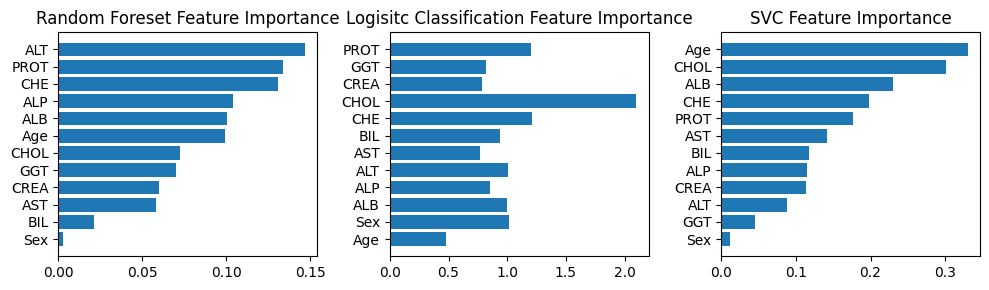


SVC 모델이 재현율, 정밀도, 정확도, F1-score에서 각각 93%로 모델의 성능이 가장 좋다. 
모델의 사용된 컬럼들 에대한 계수들을 평균 계수로 처리하여 전체 중요도를 정리한 경과 
Age, CHOL, ALB, CHE, PROT 가 간염여부에 중요한 영향을 미치는 요소라고 판단되어진다. 



In [21]:
fig, axes = plt.subplots(1, 3, figsize = (10, 3))

for name, model in model_lst :
  # Random Forest
  if name == 'rf' :
    importance = model.feature_importances_
    feature = model.feature_names_in_
    rf_imp = pd.Series(importance, feature).sort_values()

    axes[0].barh(rf_imp.index,  rf_imp.values)
    axes[0].set_title('Random Foreset Feature Importance')

  # Logistic
  elif name == 'LC' :
    odds = np.exp(model.coef_[0])
    feature = model.feature_names_in_
    lc_imp = pd.Series(odds, index = feature)

    axes[1].barh(lc_imp.index, lc_imp.values)
    axes[1].set_title('Logisitc Classification Feature Importance')

  # SVC : 계수의 평균화
  else :
    importances = abs(model.coef_).mean(axis =0)
    features = model.feature_names_in_
    feature_imp = pd.Series(importances,features).sort_values()
    axes[2].barh(feature_imp.index, feature_imp.values)
    axes[2].set_title('SVC Feature Importance')


plt.tight_layout()
plt.show()
print('''
SVC 모델이 재현율, 정밀도, 정확도, F1-score에서 각각 93%로 모델의 성능이 가장 좋다.
모델의 사용된 컬럼들 에대한 계수들을 평균 계수로 처리하여 전체 중요도를 정리한 경과
Age, CHOL, ALB, CHE, PROT 가 간염여부에 중요한 영향을 미치는 요소라고 판단되어진다.
''')

## 데이터 설명
- 데이터 출처 : https://www.data.go.kr/data/15048032/fileData.do / 후처리, 통계청 날씨정보
- 데이터 링크 :
    - ./data/p2_sb_2021.csv
    - ./data/p2_sb_2022.csv
    - ./data/p2_sb_2023.csv
    - ./data/p2_w_2021.csv
    - ./data/p2_w_2022.csv
    - ./data/p2_w_2023.csv
- 데이터 설명 :
    - 21년~23년의 J시의 2개 지하철호선 지하철의 시간대별 승하차 인원 정보 데이터 (p2_sb_년도.csv)
        - X5~ X22 : 5시부터 22시 승차 또는 하차 인원, (X5 : 05시의 계절 날짜와 대응)
        - 역번호 : 각 정류장의 고유 번호
        - 승하차구분 : 승차 또는 하차
    - 21년~23년의 J시의 특정지역구의 시간대별 게절성 정보 데이터 (p2_w_년도.csv)
        - 시간별 J시의 날씨정보

In [22]:
p = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_33회/p2_sb_2021.csv')
weather = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_33회/p2_w_2021.csv')

import os
[x for x in os.listdir('/content/drive/MyDrive/ADP_SONY/ADP_33회/') if 'p2' in x]
sb = pd.concat([pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_33회/' + x) for x in [x for x in os.listdir('/content/drive/MyDrive/ADP_SONY/ADP_33회/') if 'p2_sb' in x]]).reset_index(drop=True)
w = pd.concat([pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_33회/' + x) for x in [x for x in os.listdir('/content/drive/MyDrive/ADP_SONY/ADP_33회/') if 'p2_w' in x]]).reset_index(drop=True)


#### ✅ 4-1 아래 조건들을 참고하여 전처리를 시행하고 훈련데이터에 대한 기초통계량을 구하시오
1. 승하차 데이터에서 X5~X22 모든컬럼이 0의 값을 가지는 경우 해당 날짜,호선,역번호 승하차 행은 제외한다.
2. 승하차 데이터를 날짜,호선,역번호,시간대별(05~22시) 승객수의 총합을 구하여라(승차 + 하차), 결측치는 0명으로 간주한다. 컬럼명은 users로 변경한다.
3. 날짜 데이터의 강수 데이터는 결측치를 0, 그 외 컬럼의 결측치는 직전값으로 대치한다.
4. 날짜데이터와 일자,시간별 승하차인원 데이터를 동일날짜,시간에 대해 합친다.
5. 일자정보를 바탕으로 주말 여부를 나타내는 weekday컬럼을 추가한다. (주말=1,평일=0)
6. 21년,22년 데이터는 훈련데이터, 23년 데이터는 테스트 데이터로 사용한다.

In [23]:
# 승하차 데이터에서 X5~X22 모든컬럼이 0의 값을 가지는 경우 해당 날짜,호선,역번호 승하차 행은 제외
sb['sum']= sb.iloc[:,4:].sum(axis = 1)
sb = sb[sb['sum'] != 0].reset_index(drop = True)
sb = sb.drop(columns = 'sum', axis = 1)
sb.head(3)

,날짜,호선,역번호,승하차구분,X5,X6,X7,X8,X9,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
0,2022-01-01,A,201,승차,16.0,36,55,100,92,96,...,268,287,389,443,424,385,240,358,359,115
1,2022-01-01,A,201,하차,9.0,88,196,209,150,136,...,253,311,249,223,196,161,84,103,130,65
2,2022-01-01,A,202,승차,41.0,39,79,124,168,200,...,607,752,796,977,1377,1200,922,985,1094,417


In [24]:
# 승하차 데이터를 날짜,호선,역번호,시간대별(05~22시) 승객수의 총합을 구하여라(승차 + 하차),
#결측치는 0명으로 간주한다. 컬럼명은 users로 변경

melt_df = sb.melt(id_vars = ['날짜','호선','역번호','승하차구분'], var_name = '시간', value_name = '인원수')
melt_df.head(4)

,날짜,호선,역번호,승하차구분,시간,인원수
0,2022-01-01,A,201,승차,X5,16.0
1,2022-01-01,A,201,하차,X5,9.0
2,2022-01-01,A,202,승차,X5,41.0
3,2022-01-01,A,202,하차,X5,38.0


In [25]:
sb_pivot = melt_df.pivot_table(index = ['날짜','시간','호선','역번호'], columns = '승하차구분',values = '인원수' , aggfunc = 'sum').reset_index()
sb_pivot['users'] = sb_pivot['승차'] +  sb_pivot['하차']

#결측치는 0명으로 간주한다. 컬럼명은 users로 변경
sb_pivot['승차'] = sb_pivot['승차'].fillna(0)
sb_pivot['하차'] = sb_pivot['하차'].fillna(0)
sb_pivot['users'] = sb_pivot['users'].fillna(0)



In [26]:
# 날짜 데이터의 강수 데이터는 결측치를 0, 그 외 컬럼의 결측치는 직전값으로 대치
w['강수량']= w['강수량'].fillna(0)

for col in ['풍속', '전운량', '지면온도']:
  w[col] = w[col].fillna(method = 'bfill')

w['일시'] = pd.to_datetime(w['일시'])

In [27]:
#날짜데이터와 일자,시간별 승하차인원 데이터를 동일날짜,시간에 대해 합친다
sb_pivot['일시']=  pd.to_datetime(sb_pivot['날짜'] + ' '+sb_pivot['시간'].str.split('X').str[1])
merge_sb = sb_pivot[['일시','호선','역번호','승차','하차','users']]

merge_df = pd.merge(merge_sb, w, on = '일시', how = 'left')
merge_df.head()

,일시,호선,역번호,승차,하차,users,기온,강수량,풍속,습도,증기압,현지기압,전운량,중하층운량,지면온도
0,2021-01-01 10:00:00,A,201,53.0,110.0,163.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4
1,2021-01-01 10:00:00,A,202,103.0,356.0,459.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4
2,2021-01-01 10:00:00,A,203,60.0,118.0,178.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4
3,2021-01-01 10:00:00,A,204,57.0,99.0,156.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4
4,2021-01-01 10:00:00,A,205,146.0,210.0,356.0,-6.1,0.0,1.1,68,2.6,1016.4,1.0,1,-3.4


In [28]:
# 일자정보를 바탕으로 주말 여부를 나타내는 weekday컬럼을 추가한다. (주말=1,평일=0)
# dt.weekday : Monday=0, Sunday=6
merge_df['weekday'] = merge_df['일시'].dt.weekday.apply(lambda x : 1 if x in [5,6] else 0)

In [29]:
# 21년,22년 데이터는 훈련데이터, 23년 데이터는 테스트 데이터로 사용
train_set = merge_df[merge_df['일시'].dt.year.isin([2021, 2022])].reset_index(drop =True)
test_set = merge_df[merge_df['일시'].dt.year.isin([2023])].reset_index(drop =True)

train_set.shape
test_set.shape

(545616, 16)

#### ✅ 4-2 전체 년도 데이터에 대해 users와 날씨 정보에 대해 상관관계를 분석하고 주말여부에 따른 users 변수의 차이가 존재하는지 통계적으로 확인하라.

In [30]:
#  users와 날씨 정보에 대해 상관관계를 분석
cor_df = merge_df.drop(columns =['일시','호선','역번호', 'weekday','승차','하차'], axis = 1)
corr = cor_df.corr()
display(corr[corr.index == 'users'])
print('''
user와 날씨 정보에 대한 상관관계 분석 결과
지면온도와 풍속과 강한 양의 상관관계를 가지며, 강수량, 습도, 현지 기업, 전운량, 중하층 운량과는 음의 상관을 가진다.
날씨 정보와의 상관관계에서 0.8이상의 상관계수가 없어 데이터 중복(다중 공선성)의 우려가 낮다.
''')

,users,기온,강수량,풍속,습도,증기압,현지기압,전운량,중하층운량,지면온도
users,1.0,0.032292,-0.003306,0.049884,-0.051947,0.000272,-0.011956,-0.008724,-0.013331,0.023865



user와 날씨 정보에 대한 상관관계 분석 결과 
지면온도와 풍속과 강한 양의 상관관계를 가지며, 강수량, 습도, 현지 기업, 전운량, 중하층 운량과는 음의 상관을 가진다. 
날씨 정보와의 상관관계에서 0.8이상의 상관계수가 없어 데이터 중복(다중 공선성)의 우려가 낮다. 



In [31]:
# 주말여부에 따른 users 변수의 차이가 존재
from scipy.stats import ttest_ind
stat_df = merge_df[['weekday','users']]

g1 = stat_df[stat_df['weekday']== 1]['users']
g2 = stat_df[stat_df['weekday']== 0]['users']

stat, p_val = ttest_ind(g1, g2)
print(f'''
귀무가설 : 주말 여부에 따른 users의 차이가 없다.
대립가설 : 주말 여부에 따른 users의 차이가 있다.
{p_val} < 0.05 으로 귀무가설을 기각하여, 주말 여부에 따른 users의 차이가 있다.
''')


귀무가설 : 주말 여부에 따른 users의 차이가 없다. 
대립가설 : 주말 여부에 따른 users의 차이가 있다. 
0.0 < 0.05 으로 귀무가설을 기각하여, 주말 여부에 따른 users의 차이가 있다. 



#### ✅ 4-3 users를 예측하는 2가지 회귀모델을 학습하고 모델에 대해 평가하라 (선형회귀 모델은 1개 필수 포함)

In [32]:
x_train = train_set.drop(columns = ['일시','users','역번호'])
y_train = train_set['users']

train_dummies = pd.get_dummies(x_train['호선'], dtype = int)
scaled_x = x_train.drop(columns = ['weekday','호선'])
ss = StandardScaler()
scaled_x = pd.DataFrame(ss.fit_transform(scaled_x), columns = scaled_x.columns)
## X_train, y_train
final_x_train = pd.concat([scaled_x, train_dummies], axis = 1)
y_train = train_set['users']


x_test = test_set.drop(columns = ['일시','users','역번호'])
test_dummies = pd.get_dummies(x_test['호선'], dtype = int)
scaled_x_test = x_test.drop(columns = ['weekday','호선'])
ss = StandardScaler()
scaled_x_test = pd.DataFrame(ss.fit_transform(scaled_x_test), columns = scaled_x.columns)

# X_test , y_test
final_x_test = pd.concat([scaled_x, test_dummies], axis = 1)
y_test = test_set['users']



In [32]:
print('''
선형 회귀 모델인 Linear Regression과 비선형 회귀 모델인 Random Forest Regressor를 사용하여 예측을 수행한다.

1) Linear Regression
- 독립변수와 종속변수 간의 선형 관계를 가정하는 가장 기본적인 회귀 모델이다.
- 모델이 단순하고 해석력이 뛰어나므로, 변수 간 관계 파악과 베이스라인 성능 측정에 유용하다.
- 다만, 변수 간 선형성 가정이 만족되지 않거나 상호작용이 존재하는 경우에는 성능이 제한될 수 있다.

2) Random Forest Regressor
- 여러 개의 결정 트리를 앙상블하여 예측을 수행하는 비선형 회귀 모델이다.
- 변수 간 복잡한 비선형 관계를 잘 포착하며, 과적합에도 상대적으로 강건한 특성을 가진다.
- 변수 중요도를 자동으로 추출할 수 있어, 예측뿐 아니라 변수 해석에도 활용 가능하다.

📌 두 모델을 비교함으로써, 데이터가 선형적인 구조를 가지는지 또는 비선형적 특성이 강한지를 판단할 수 있으며,
해석력과 예측력 간의 균형을 고려한 모델 선택이 가능하다.
''')

def eval_model(name, model) :
  model.fit(final_x_train, y_train)
  pred = model.predict(final_x_test)
  mse = mean_squared_error(y_test, pred )
  r2 = r2_score(y_test, pred)

  return mse, r2

res = []
model_lst= []
for name, model in [['rf' , RandomForestRegressor()] , ['LC', LinearRegression()]] :
  mse, r2 = eval_model(name, model)
  res.append([name, mse, r2])
  model_lst.append([name, model])


linear_result = pd.DataFrame(res, columns = ['Model_Name', 'MSE', 'r2'])
display(linear_result)

#### 📊 통계 (40점)

## 데이터 설명
- 데이터 출처 : 자체 제작
- 데이터 링크 : ./data/s1.csv
- 데이터 설명 : A,B 두 공장의 특정 일자의 수율(%)데이터. 단, 불량률은 (100 - 수율)로 정의한다.
    

In [33]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_33회/s1.csv')
df.head()

,year,month,day,A,B
0,2023,Sep,7,56.9,42.3
1,2023,Feb,20,100.0,89.0
2,2023,Jun,15,19.3,59.0
3,2023,Apr,11,98.0,84.8
4,2023,Jul,8,89.5,63.8


## 5-1 공장별 결측치, 기초통계량 등을 확인하라

year     0
month    0
day      0
A        5
B        5
dtype: int64


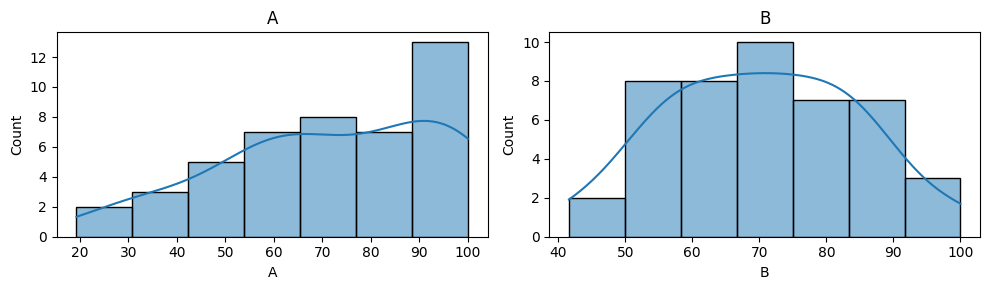

,count,mean,std,min,25%,50%,75%,max
A,45.0,72.064444,22.892805,19.3,57.2,72.1,89.6,100.0
B,45.0,70.306667,14.352865,41.6,59.0,70.7,81.7,100.0



A공장의 경우, 오른족으로 점점 증가하는 분포를 띄며, B의 경우 종 모양의 분포를 가진다. 
A 공장의 평균이 72로 B공장보다 다소 높으며, 표준편차에서 차이가 나지만, 눈에 띄는 점은 
최고 값이 A공장 20, B공장이 41로 B공장의 수율의 최소 40% 이상이라는 점이 특징이다.



In [34]:
print(df.isna().sum())

fig, axes = plt.subplots(1, 2, figsize = (10,3))
for  i, col in enumerate(['A','B']) :
  sns.histplot(df[col], ax = axes[i], kde= True)
  axes[i].set_title(col)

plt.tight_layout()
plt.show()
display(df[['A','B']].describe().T)
print('''
A공장의 경우, 오른족으로 점점 증가하는 분포를 띄며, B의 경우 종 모양의 분포를 가진다.
A 공장의 평균이 72로 B공장보다 다소 높으며, 표준편차에서 차이가 나지만, 눈에 띄는 점은
최고 값이 A공장 20, B공장이 41로 B공장의 수율의 최소 40% 이상이라는 점이 특징이다.
''')

## 5-2 A,B 공장의 불량률 차이가 존재하는지 확인하려 한다. 귀무,대립 가설을 설정하고 설명하라

In [35]:
# 데이터가 50개 - 정규성, 등분산성

# A, B 결측 평균 대체
df['A'] = df['A'].fillna(df['A'].mean())
df['B'] = df['B'].fillna(df['B'].mean())

# 정규성 검토
A = df['A']
B = df['B']

a_stat, a_pval = stats.shapiro(A)
b_stat, b_pval = stats.shapiro(B)
print(f'''
귀무가설 : 데이터의 분포는 정규 분포이다.
대립가설 : 데이터의 분포는 정규 분포가 아니다.

A 공장 : {a_pval} < 0.05
B 공장 : {b_pval} > 0.05
으로 A공장의 데이터는 정규 분포가 아니다.
비모수 검정인 wilcox으로 두 집단의 차이를 검정한다.
''')

from scipy.stats import mannwhitneyu
stat, p_val = mannwhitneyu(A, B, alternative='two-sided')



print(f'''
귀무가설 : A,B공장의 불량률 차이가 존재하지 않는다.
대립가설 : A,B공장의 불량률 차이가 존재한다.
p_val 가 {p_val} > 0.05으로  A,B공장의 불량률 차이가 존재하지 않는다.
''')



귀무가설 : 데이터의 분포는 정규 분포이다.
대립가설 : 데이터의 분포는 정규 분포가 아니다. 

A 공장 : 0.015296006567744753 < 0.05
B 공장 : 0.8072348628390171 > 0.05 
으로 A공장의 데이터는 정규 분포가 아니다. 
비모수 검정인 wilcox으로 두 집단의 차이를 검정한다. 


귀무가설 : A,B공장의 불량률 차이가 존재하지 않는다. 
대립가설 : A,B공장의 불량률 차이가 존재한다. 
p_val 가 0.377411102998617 > 0.05으로  A,B공장의 불량률 차이가 존재하지 않는다. 



## 5-3 A,B의 차이가 있는지 통계검정 하고 설명하라

## 데이터 설명
- 데이터 출처 : https://www.data.go.kr/data/15123586/fileData.do 후처리
- 데이터 링크 : ./data/s2.csv
- 데이터 설명 : 일자별 지하철 노션별 지연 데이터

In [36]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_33회/s2.csv')
df.head()

,지연ID,지연일자,노선,최대지연시간
0,ID_0,2023-09-01,1호선,15분
1,ID_1,2023-09-01,1호선,15분
2,ID_2,2023-09-01,4호선,10분
3,ID_3,2023-09-01,4호선,10분
4,ID_4,2023-09-04,4호선,10분


In [37]:
df['최대지연시간'] = df['최대지연시간'].str.split('분').str[0].astype(int)

## 6-1 노선에 상관없이 일별 최대 지연시간이 5~15분으로 발생하는 경우는 하나의 사건으로 보자. 해당 사건이 일자별 발생하는 빈도가 푸아송분포를 따르는지 확인하는 방법 2가지를 기술하고 결과를 보여라

In [38]:
#df['최대지연시간'].value_counts()

# 평균 지연 시간
mean = np.mean(df['최대지연시간'])

# 각 지연 시간의 관측 빈도
obs_freq = df['최대지연시간'].value_counts().sort_index()

# 기대빈도 - 각 지연 시간 마다의 포아송의 기대빈도
poisson_prob = [stats.poisson.pmf(k, mean) for k in obs_freq.index]

expected_freq = np.array(poisson_prob) * obs_freq.sum()

# 기대빈도 합
expected = expected_freq * (obs_freq.sum() / expected_freq.sum())

chi2_stat, p_value = stats.chisquare(f_obs = obs_freq.values, f_exp = expected)
print(f"카이제곱 통계량: {chi2_stat}")
print(f"p-value: {p_value}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("귀무가설 기각: 지연 시간은 포아송 분포를 따르지 않는다.")
else:
    print("귀무가설 채택: 지연 시간은 포아송 분포를 따른다.")

카이제곱 통계량: 29617.649538464797
p-value: 0.0
귀무가설 기각: 지연 시간은 포아송 분포를 따르지 않는다.


## 6-2 10분이하, 10분초과 -20분 이하, 20분초과  3가지로 지연시간을 지연정도로 분류하라. 호선별 지연정도를 교차표로 구하여라

In [39]:
def delay(x) :
  if x <= 10 :
    return '10분이하'
  elif x <= 20 :
    return '10분초과_20분이하'
  else :
    return '20분초과'

df['지연정도'] = df['최대지연시간'].apply(delay)

## 6-3 지하철 호선별로 지연정도가 차이가 있는지 확인하려한다. 귀무가설과 대립가설을 설정한 후 통계 검정을 실시하라

In [40]:
chi_df = pd.crosstab(df['노선'],df['지연정도'])

stat, p_val, dof, expected = stats.chi2_contingency(chi_df)
print(f'''
귀무가설 : 지하철 호선별로 지연정도는 독립이다.
대립가설 : 지하철 호선별로 지연정도는 독립이 아니다.

{p_val} < 0.05로 귀무가설을 기각하여, 지하철 호선별로 지연정도는 독립이 아니다.
즉, 지하철 호선별로 지연정도의 분포가 달라진다.
''')


귀무가설 : 지하철 호선별로 지연정도는 독립이다. 
대립가설 : 지하철 호선별로 지연정도는 독립이 아니다. 

0.0009748725028849682 < 0.05로 귀무가설을 기각하여, 지하철 호선별로 지연정도는 독립이 아니다. 
즉, 지하철 호선별로 지연정도의 분포가 달라진다.



## 데이터 설명
- 데이터 출처 : 자체제작
- 데이터 링크 : ./data/s3.csv
- 데이터 설명 : 시계열 정보를 가지는 250행의 데이터

In [41]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_33회/s3.csv')
df.columns = ['value']
df.head()

,value
0,0.308778
1,0.692133
2,2.070861
3,1.326845
4,0.077552


## 7-1 ar ma arma에 대해 설명하고, ACF, PACF는 패턴을 통해 설명하라.


AR (자기 회귀 모형)
  - 현재 시점의 값이 과거 값의 선형 결합으로 설명되는 모델 
  - 즉, 과거의 데이터의 영향을 반영 

MA (이동 평균 모형)
  - 현재 시점의 값이 과거의 오차항의 선형 결합으로 설명되는 모델 

ARMA - AR과 MA를 결합한 모형으로 과거값과 오차의 영향을 받는 것을 반영한 모형 
     - 대부분의 정상 시계열 데이터는 ARMA 모델로 적절히 설명이 가능



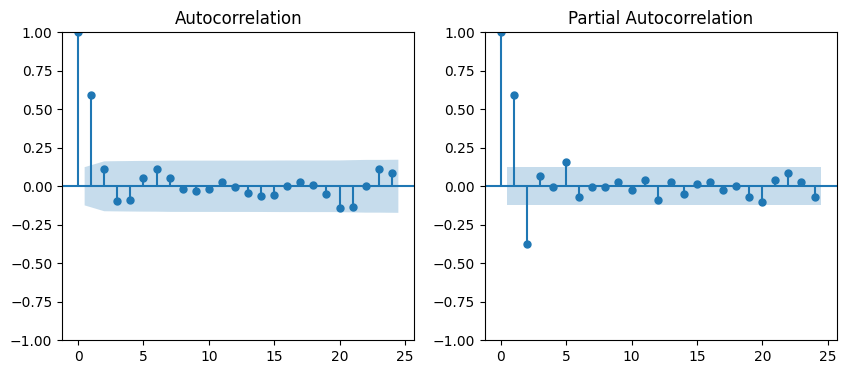

In [42]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

print('''
AR (자기 회귀 모형)
  - 현재 시점의 값이 과거 값의 선형 결합으로 설명되는 모델
  - 즉, 과거의 데이터의 영향을 반영

MA (이동 평균 모형)
  - 현재 시점의 값이 과거의 오차항의 선형 결합으로 설명되는 모델

ARMA - AR과 MA를 결합한 모형으로 과거값과 오차의 영향을 받는 것을 반영한 모형
     - 대부분의 정상 시계열 데이터는 ARMA 모델로 적절히 설명이 가능
''')

fig, ax = plt.subplots(1,2, figsize = (10, 4))
plot_acf(df, ax = ax[0])
plot_pacf(df, ax = ax[1])
plt.show()

## 7-2 Acf pacf를 그리고 해석하라, 해당 Plot data를 기반으로 ARMA(p,q)모형 제시하라

In [1]:
print('''
1) ACF (MA): 현재값과 과거값의 상관관계를 측정 - 전체 시계열 구조에서 lag k가 얼마나 중요한지 나타냄
        시차 0에서 상관계수는 1 (자기 자신과의 상관)
        시차 1에서 상관계수 0.6으로 유의미
        시차 2에서부터 파란색 영역으로 들어가며 0 근처에서 변동 즉, 시차 1이후에 상관이 유의하지 않음
        MA(1) 모형

2) PCAF (AR): 현재와 특징 lag 만의 관계 즉, Lag자체가 독립적으로 얼마나 중요한가를 나타냄
        시차 0에서 부분 자기 상관계수 1
        시차 1에서 0.75로 유의미
        시차 2에서 -0.25으로 신뢰구간 밖에 있지만 시차 3부터 신뢰구간내로 들어감
        AR(1) 혹은 AR(2)

PACF의 시차 2이후 패턴이 약함으로, AR(1)을 고려하며 ARMA(1,1) 이 적합해보인다.
''')



1) ACF (MA): 현재값과 과거값의 상관관계를 측정 - 전체 시계열 구조에서 lag k가 얼마나 중요한지 나타냄
        시차 0에서 상관계수는 1 (자기 자신과의 상관)
        시차 1에서 상관계수 0.6으로 유의미 
        시차 2에서부터 파란색 영역으로 들어가며 0 근처에서 변동 즉, 시차 1이후에 상관이 유의하지 않음 
        MA(1) 모형 

2) PCAF (AR): 현재와 특징 lag 만의 관계 즉, Lag자체가 독립적으로 얼마나 중요한가를 나타냄 
        시차 0에서 부분 자기 상관계수 1 
        시차 1에서 0.75로 유의미
        시차 2에서 -0.25으로 신뢰구간 밖에 있지만 시차 3부터 신뢰구간내로 들어감 
        AR(1) 혹은 AR(2)

PACF의 시차 2이후 패턴이 약함으로, AR(1)을 고려하며 ARMA(1,1) 이 적합해보인다. 

